In [13]:
from pickle import load
import os
import torch
from utils import SimplexEnvironment

MDP = load(open(os.path.join("data", "mdps", "small" ,"small_mdp.bin"), 'rb'))
t = torch.from_numpy(MDP.get_transitions()).to(torch.float32)

100%|██████████| 10/10 [00:00<00:00, 3333.57it/s]


In [14]:
print( MDP.S, MDP.A, MDP.d)

100 10 3


We will use a Neural Network To approximate the embedding functions of our MDP.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [16]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
class Net(nn.Module): 
    def __init__(self, states, actions, d):
        super(Net, self).__init__()
        self.states = states
        self.actions = actions
        self.d = d
        self.device = 'cpu'
    
        self.l1 = nn.Linear(self.states + self.actions, 240)  #First Linear layers, Receives concat onehot enconding of state-action pair
        self.l2 = nn.Linear(240, 80)
        # self.bn1 = nn.BatchNorm1d(num_features=1)
        self.embedding = nn.Linear(80, self.d)
        init_params = torch.full((self.d, self.states), 1/self.states) + torch.rand((self.d, self.states))
        self.mu_weights = nn.Parameter(init_params)
    
    def to(self, device):
        self.device = device
        super(Net, self).to(device)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()


    def encode_input(self, s, a):
         """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
         input_len = len(s) if hasattr(s, '__len__') else 1
         actions_len = len(a) if hasattr(a, '__len__') else 1
         assert input_len == actions_len, f"The input lenghts do not coincide. Input States: {input_len}; Input Actions: {actions_len}"

         s_hot = F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)
         a_hot = F.one_hot(a.view(input_len, 1), self.actions).to(torch.float32)
         x = torch.cat((s_hot, a_hot), dim=-1)# Concat one hot vectors 
         return x.to(self.device)

    def enconde_output(self, s):
        input_len = len(s) if hasattr(s, '__len__') else 1
        return F.one_hot(s.view(input_len, 1), self.states).to(torch.float32)


    def phi(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
         """
        
        x = self.encode_input(s, a) 
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        # x = self.bn1(x)
        x = F.softmax(self.embedding(x), dim=-1) # Apply softmax row wise

        return x # This should be of shape (batch_size, 1, d)

    def mu(self):
        return F.softmax(self.mu_weights, dim=-1)

    def forward(self, s, a):
        """
        # Parameters:
        s: State id or list like of state ids between 0 and self.states
        a: Action id or list like of actions ids between 0 and self.actions

        If s and a are list-like, both need to be the same lenght
        """
        x = self.phi(s, a)
        soft_mu = self.mu()

        # We use bradcasting in here so the same parameters are used for every element of the batch
        x = torch.matmul(x, soft_mu) # Mat multiplication of (batch_size, 1, d) @ (d, states) --> (batch_size, 1, states) # Distribution over states

        return x.view(-1, self.states)

    def phi_a_matrix(self, a):
        """Calculates the transition kernes induces by phi when one action a is fixed.
        # Parameters:
        a: Action id between 0 and self.actions - 1
         """
        actions_list = a.repeat(self.states)
        state_list = torch.arange(0, (self.states), dtype=int)

        with torch.no_grad():
            phi_a_batch = self.phi(state_list, actions_list).view(self.states, self.d) # This should be of shape (states, d)

            return torch.matmul(phi_a_batch, self.mu()) # Should be size (states, states)


net = Net(MDP.S, MDP.A, MDP.d)

In [18]:
net.parameters

<bound method Module.parameters of Net(
  (l1): Linear(in_features=110, out_features=240, bias=True)
  (l2): Linear(in_features=240, out_features=80, bias=True)
  (embedding): Linear(in_features=80, out_features=3, bias=True)
)>

In [19]:
# net.phi_a_matrix(torch.tensor(1)).size()

In [20]:
# torch.isclose(torch.ones((net.states)), torch.sum(net.phi_a_matrix(torch.tensor(1)), dim=-1), 0.001)

In [21]:
from pickle import load

train_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_train.bin"), 'rb'))
test_path = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_path_test.bin"), 'rb'))

print(len(train_path)/ (len(train_path) + len(test_path)))


0.7


In [22]:
from utils import ListDataset

batch_size = 64
train_dataset = ListDataset(train_path, batch_size=batch_size)

In [23]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loder_len = len(train_path)

In [24]:
net.to(device)

Training Loop

In [25]:
%%time
from tqdm import tqdm

losses = []
avg_losses = []
batch_losses = []
frob_diff = []
t = torch.from_numpy(MDP.get_transitions())
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    avg_loss = 0.0
    with tqdm(enumerate(train_dataset, 0), total=(loder_len // batch_size)) as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}.  ")

            # get the inputs; data is a list of [inputs, labels]
            input_states, input_actions, labels = data[0].to(device), data[1].to(device), data[2].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = torch.log(net(input_states, input_actions))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss.item())
            running_loss += loss.item()

            if i % 10 == 9:    # print every 10 mini-batches
                tepoch.set_postfix(loss=f'{running_loss / 10:.3f}')
                batch_losses.append(running_loss / 10)
                running_loss = 0.0

            if i % 10 == 9:
                with torch.no_grad():
                    m0 = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                    for i in range(1, MDP.A):
                        ma = net.phi_a_matrix(torch.tensor(0)).detach().unsqueeze(0).to("cpu")
                        m0 = torch.cat((m0, ma), dim=0)
                        
                    frob = torch.norm((m0-t))
                    frob_diff.append(frob)
                    

                    
        
        avg_losses.append(running_loss / (loder_len // batch_size))



print('Finished Training')

Epoch 2.  : 100%|██████████| 4533/4533 [00:52<00:00, 86.93it/s, loss=4.132]

Finished Training
CPU times: total: 13min 24s
Wall time: 2min 20s


Text(0, 0.5, 'NLLLoss')

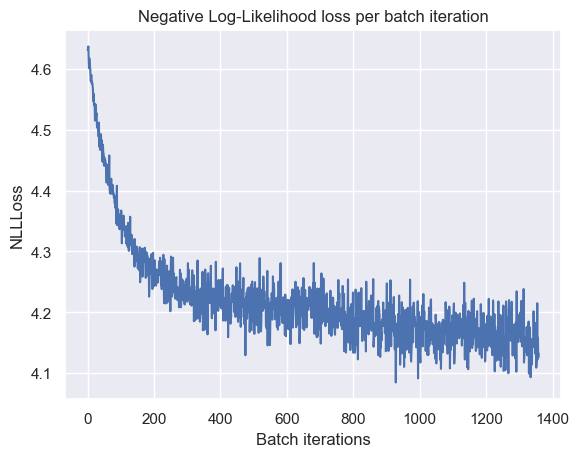

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
plt.plot(batch_losses)
plt.title("Negative Log-Likelihood loss per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("NLLLoss")
# plt.savefig("./images/small_mdp_loss_lg_emb.pdf",format="pdf", bbox_inches="tight")

Next will be the behaviour of our net in term of difference of frobenius norm. This can help us do a relatively easy comparative between this approach and others like sGS_ADMM_MDPs

Text(0, 0.5, '$\\sum_{a \\in \\mathcal{A}}||X_a - M_a||_{fb}$')

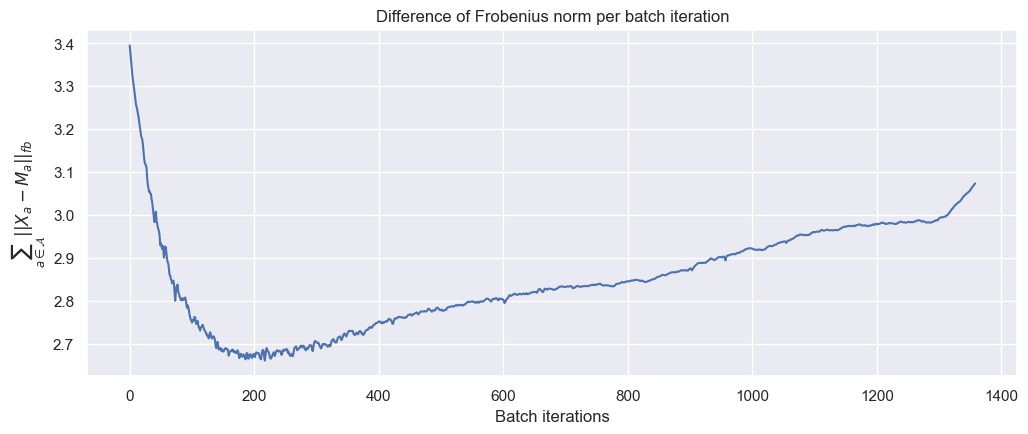

In [27]:
# frob_diff_batch = [i for i in frob_diff for j in range(5)]
plt.figure(figsize=(12, 4.5))
plt.plot(frob_diff)
plt.title("Difference of Frobenius norm per batch iteration")
plt.xlabel("Batch iterations")
plt.ylabel("$\sum_{a \in \mathcal{A}}||X_a - M_a||_{fb}$")
# plt.savefig("./images/small_mdp_fb_diff_lg_emb.pdf",format="pdf", bbox_inches="tight")

Optimal Value Function and Policy

In [11]:
%%time
from utils import PolicyIteration
import numpy as np

def reward(s_prev, a, s_next):
    return np.log(s_prev + 1) + np.log(a + 1) + np.log(s_next + 1)

def next_state_prob(s, a):
            with torch.no_grad():
                return net.forward(torch.from_numpy(s.ravel()).to(net.device).long(), 
                                    torch.from_numpy(a.ravel()).to(net.device).long()).to("cpu").numpy()

pol_iter = PolicyIteration(net.states , net.actions, next_state_prob , reward)

v, pol = pol_iter.run()

  0%|          | 1/2000 [00:00<00:16, 124.50it/s]

CPU times: total: 31.2 ms
Wall time: 32 ms


In [12]:
from pickle import load

v_true, pol_true = load(open(os.path.join("data", "mdps", "small" ,"small_mdp_optimals.bin"), 'rb'))

np.mean(np.abs(v - v_true))

0.03470107673441853